In [70]:
import pandas as pd
import seaborn as sns
import numpy as np

# Select block size for parallelizing traf.py

In [71]:
df = pd.read_csv('./select_traf_blocksize/blocksize.tsv', sep='\t', header=None)
df =  df.rename(columns={0:'file',1:'size',2:'bs',3:'time'})
df.head()

,file,size,bs,time,4
0,/users/arefevni/hplt/two/html_sample0.01_bs10/...,2112108,3M,1m32.384s,NaN
1,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1531912,3M,0m57.249s,NaN
2,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1652148,3M,1m11.109s,NaN
3,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1948860,3M,1m23.885s,NaN
4,/users/arefevni/hplt/two/html_sample0.01_bs10/...,1040888,3M,0m48.125s,NaN


In [72]:
df.time = pd.to_datetime(df.time, format='%Mm%S.%fs') - pd.to_datetime('0', format='%S')

df.time = df.time.dt.total_seconds()

df['size-bin'] = pd.qcut(df['size'] / 2**20, q=10)

In [73]:
df['size-bin-left'] = df['size-bin'].apply(lambda r: r.left)

In [78]:
df['sec_per_GBcompressed'] = df['time'] / (df['size']*1024 / 2**20)  # du -a generates df['size'] in KB

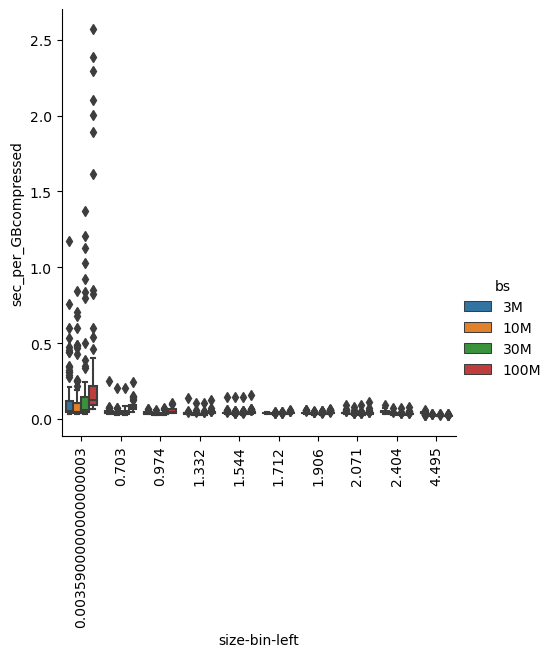

In [79]:
g =  sns.catplot(data=df, x='size-bin-left', y='sec_per_GBcompressed', hue='bs', kind='box')
g.set_xticklabels(rotation=90)

Block size 100 MB is suboptimal for files < 2.5 GB. Probably not all cpus are occupied.
Block size 3 MB is very suboptimal for files > 2 GB. Init cost starts playing its role.
Block size 30 MB looks best accross the experimental range.
##### Block size 30 MB for trafilatura is selected

# Select traf.py timeout

In [75]:
dfd = pd.read_csv('./select_traf_timeout/dur_nofallback_sampled.zst', header=None)
dfd.head()

,0
0,0.0088
1,0.0071
2,0.0270
3,0.0130
4,0.0013


In [95]:
dfd[0].describe(percentiles=[.95,.99,.995,.997,.999])

count    1000000.000000
mean           0.034255
std            0.133266
min            0.000100
50%            0.014000
95%            0.120000
99%            0.310000
99.5%          0.450000
99.7%          0.570000
99.9%          1.100000
max           37.000000
Name: 0, dtype: float64

<Axes: ylabel='Proportion'>

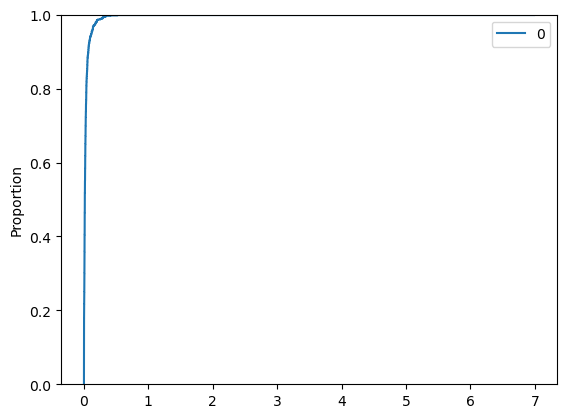

In [77]:
sns.ecdfplot(dfd.sample(1000))

In [89]:
!pwd

/home/nikolare/_projects/hplt/warc2text-runner/two/stage2_hypers


In [90]:
dfc = pd.read_csv('./select_traf_timeout/doc_cnts_portion1.zst', header=None)
dfc.head()

,0
0,19538214
1,19449774
2,19933541
3,19737386
4,19829708


We have 2 days = 48 hours time limit for bs=1000

In [97]:
timeout = 0.5 #seconds
nproc = 200
((dfc[0] / nproc * timeout) / 3600).describe()

count    2581.000000
mean       13.975669
std         5.819919
min         1.341302
25%        10.908780
50%        13.361026
75%        14.036738
max        37.781899
Name: 0, dtype: float64

Even if it takes 0.5s for each doc, we should fit.
##### Select timout 0.5s, should loose less than 0.5% of docs

In [100]:
secperdoc_avg = dfd[0].mean()
print(secperdoc_avg)

0.03425524465000001


In [105]:
(dfc*secperdoc_avg / nproc / 3600).describe()

,0
count,2581.000000
mean,0.957480
std,0.398725
min,0.091893
25%,0.747366
50%,0.915370
75%,0.961664
max,2.588456


Portion1: Stage2, traf.py for 1 input file should take 1h on avg, 2.6h maximum

# Selecting traf/lid process ratio, 25 random files from portion1

For 25 randomly selected files from portion1, traf was run in 100 processes, then separately on its outputs lid 
was run in 100 processes. Based on running time rations we should select the process ratio.

In [65]:
df = pd.read_csv('./select_traf_lid_process_ratio/sequential_traf_lid_100proc.tsv', sep='\t', header=None)
df =  df.rename(columns={0:'file',1:'size',2:'traf_bs',3:'lid_bs',4:'traf_time', 5:'lid_time'})
df.head()

,file,size,traf_bs,lid_bs,traf_time,lid_time,6
0,/users/arefevni/hplt/two/html_sample0.01_bs10/...,354784,30M,100M,0m26.351s,0m19.702s,NaN
1,/users/arefevni/hplt/two/html/wide00006/382/ht...,35576860,30M,100M,16m29.991s,0m56.451s,NaN
2,/users/arefevni/hplt/two/html_sample0.01_bs10/...,3192420,30M,100M,2m25.741s,0m28.703s,NaN
3,/users/arefevni/hplt/two/html/wide00017/565/ht...,80494948,30M,100M,45m43.677s,2m11.329s,NaN
4,/users/arefevni/hplt/two/html/wide00017/61/htm...,83632364,30M,100M,46m32.316s,2m43.805s,NaN


In [66]:
for c in ('traf_time','lid_time'):
    q = df[c].str.split('m', expand=True)
    q[0] = q[0].astype(int)    
    df[c] = q.apply(lambda r: '%dh%dm%s' % (r[0]//60, r[0]%60, r[1]), axis=1)
    
    df[c] = pd.to_datetime(df[c], format='%Hh%Mm%S.%fs') - pd.to_datetime('0', format='%S')
    df[c] = df[c].dt.total_seconds()
df = df[df.file.str.contains('/html/')]
df

,file,size,traf_bs,lid_bs,traf_time,lid_time,6
1,/users/arefevni/hplt/two/html/wide00006/382/ht...,35576860,30M,100M,989.991,56.451,NaN
3,/users/arefevni/hplt/two/html/wide00017/565/ht...,80494948,30M,100M,2743.677,131.329,NaN
4,/users/arefevni/hplt/two/html/wide00017/61/htm...,83632364,30M,100M,2792.316,163.805,NaN
5,/users/arefevni/hplt/two/html/wide00017/421/ht...,80482556,30M,100M,2787.817,135.138,NaN
6,/users/arefevni/hplt/two/html/wide00011/10/htm...,179859684,30M,100M,5367.509,256.676,NaN
7,/users/arefevni/hplt/two/html/wide00011/6/html...,189476196,30M,100M,5663.725,244.431,NaN
8,/users/arefevni/hplt/two/html/wide00017/712/ht...,81494348,30M,100M,2760.584,139.629,NaN
9,/users/arefevni/hplt/two/html/wide00011/402/ht...,178045364,30M,100M,5326.765,307.508,NaN
10,/users/arefevni/hplt/two/html/CC-MAIN-2022-40/...,631190192,30M,100M,12372.209,738.191,NaN
11,/users/arefevni/hplt/two/html/wide00005/203/ht...,137639664,30M,100M,3790.951,266.882,NaN


In [67]:
(df['traf_time'] / df['lid_time']).describe()

count    26.000000
mean     17.812938
std       3.273286
min       9.112049
25%      16.140631
50%      17.977144
75%      20.158177
max      23.396228
dtype: float64

lid is 18x lower than traf on average; 
we left 10x ratio (26 traf processes, 224 lid processes) to account for 

In [53]:
(df['traf_time']/3600).describe()

count    26.000000
mean      1.022583
std       0.581126
min       0.274998
25%       0.768720
50%       0.805910
75%       1.073827
max       3.436725
Name: traf_time, dtype: float64

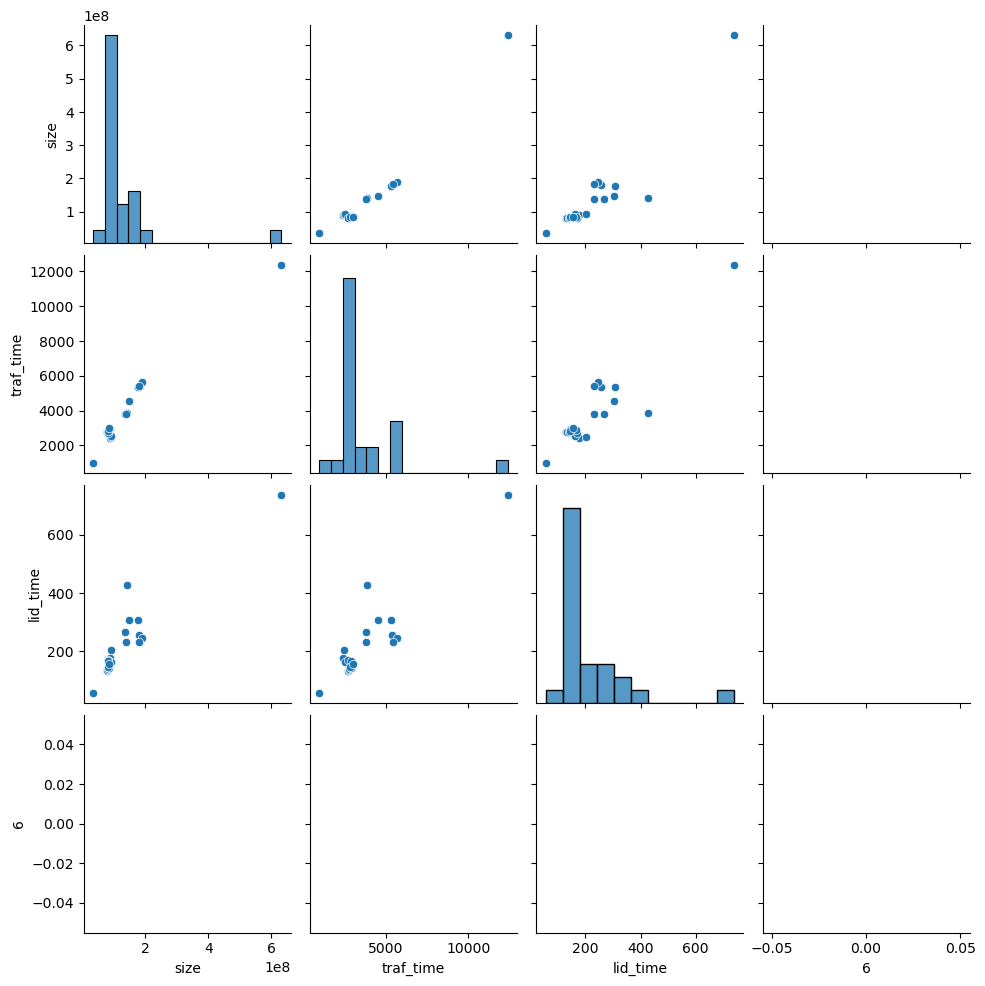

In [55]:
sns.pairplot(df)